<center>
    <h3> Real-Time Time Dependent Orbital Free Density Functional Theory with DFTpy</h3>
    <h3>Part 2: Accurate ground state density</h3>
</center>
<table>
  <tr>
      <td><p><h4>Rutgers University-Newark</h4></p><p>Team Rutgers</p></td>
           <td><img src="../figures/logos/run.png" width=300 height=300 /></td>
  </tr>
</table>

<center><h3>ASESMA 2025</h3></center>

## This notebook will:
#### 1) Obtain a good initial density with a good, computationally expensive, nonlocal functional (LMGP)
#### 2) Compute the Optical Spectra (plasmons) of a Mg<sub>8</sub> cluster from a good initial density  
#### 3) Challenge: Obtain the spectrum of your own cluster

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dftpy.grid import DirectGrid
from dftpy.field import DirectField
from dftpy.functional import Functional, TotalFunctional
from dftpy.optimization import Optimization
from dftpy.td.propagator import Propagator
from dftpy.td.hamiltonian import Hamiltonian
from dftpy.utils.utils import calc_rho, calc_j
from dftpy.td.utils import initial_kick
from dftpy.ions import Ions
from dftpy.formats import io
from dftpy.constants import Units
from dftpy.td.utils import calc_spectra_mu

In [ ]:
!wget https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg8.vasp
!wget https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg_OEPP_PZ.UPF

### Read the vasp file with DFTpy

In [10]:
ions = io.read('Mg8.vasp', format='vasp', names=['Mg'])

<Axes: >

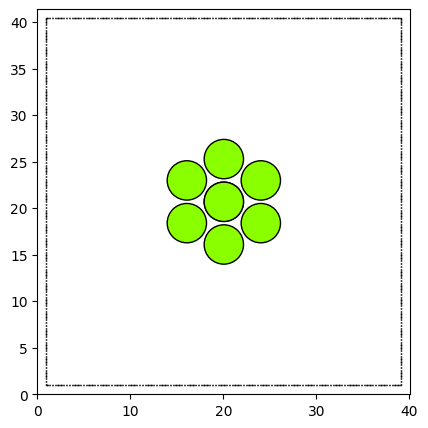

In [11]:
from ase.visualize.plot import plot_atoms
fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(ions, ax, radii=1.5, rotation=('0x,0y,0z'))

### Create the PP list and the Grid
DirectGrid is a class object that represents a grid (Cell plus discretization)

In [12]:
PP_list = ['./Mg_OEPP_PZ.UPF']
grid = DirectGrid(ions.cell, spacing = 1.1)

In [13]:
grid.nr

array([36, 36, 32], dtype=int32)

### Define XC, PSEUDO and HARTREE functionals

In [14]:
xc = Functional(type='XC',name='LDA')
hartree = Functional(type='HARTREE')
pseudo = Functional(type='PSEUDO', grid=grid, ions=ions, PP_list=PP_list)

setting key: Mg -> ./Mg_OEPP_PZ.UPF


### Initial guess of the electron density: UEG

In [28]:
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume

### Write the optimization options and build the class that handles the electron density optimization

#### Run the optimization of the electronic density with TF0.2vW ($T_s[n]\sim T_{TF}[n]+ 0.2 T_{vW}[n]$)

- The Thomas Fermi functional is
$$ T_{TF}[n] = C_{TF} \int n^{5/3}(r)dr $$

- The von Weizsacker functional is
$$ T_{vW}[n] = -\frac{1}{2} \int \sqrt{n(r)} \nabla^2 \sqrt{n(r)} dr $$

In [16]:
optimization_options = {'econv' : 1e-9,'maxiter' : 100}
ke = Functional(type='KEDF',name='TFvw', y=0.2)

totalfunctional = TotalFunctional(KEDF=ke, XC=xc, HARTREE=hartree, PSEUDO=pseudo)

opt = Optimization(EnergyEvaluator=totalfunctional, optimization_options = optimization_options,
        optimization_method = 'TN')

In [17]:
rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.951916882520E+00      8.951917E+00    2.343046E+00    1       1       4.464197E-02    
!WARN: Change to steepest decent
1       -5.391241844465E+00     -1.434316E+01   1.315224E+00    1       3       7.289386E-02    
2       -6.787012645229E+00     -1.395771E+00   1.519794E-01    2       2       9.905982E-02    
3       -7.028248145499E+00     -2.412355E-01   1.639106E-02    5       3       1.454799E-01    
4       -7.058369908191E+00     -3.012176E-02   1.701910E-03    5       2       1.841090E-01    
5       -7.059908530812E+00     -1.538623E-03   1.781677E-04    3       2       2.121341E-01    
6       -7.060408861365E+00     -5.003306E-04   1.085856E-05    6       3       2.594359E-01    
7       -7.060419731847E+00     -1.087048E-05   1.330571E-06    4       3       2.955801E-01    
8       -7.060420451061E+00     -7.192140E-07   6.551728E-07    3       3       3.286419E-01  

In [20]:
kfmax=( np.max(rho) * 3 * np.pi )**(1.0/3.0)

# Now we optimize the electron density with a more accurate functional

$$ T_{LMGP}[n] = T_{TF}[n]+T_{vW}[n]+T_{NL}[n]$$

where

$$ T_{NL}[n] = \int dr dr' \omega[n](|r-r'|) n^{5/6}(r)n^{5/6}(r')$$

where $\omega$ is a kernel function. See [this paper](https://pubs.aip.org/aip/jcp/article/148/18/184107/195885) and [this paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.100.041105) for details, as well as [this review](https://pubs.acs.org/doi/abs/10.1021/acs.chemrev.2c00758).

### If you want to skip the optimization, just read the LMGP density with DFTpy

In [15]:
#rho0 = io.read_density('rho_lmgp.xsf', full=True)

### Otherwise, execute the following cells

In [26]:
optimization_options = {'econv' : 1e-7*ions.nat,'maxiter' : 100}

In [27]:
ke = Functional(type='KEDF',name='LMGP', ratio=1.15, kfmax=kfmax+0.1)
totalfunctional = TotalFunctional(KEDF=ke, XC=xc, HARTREE=hartree, PSEUDO=pseudo)
opt = Optimization(EnergyEvaluator=totalfunctional, optimization_options = optimization_options,
        optimization_method = 'CG')
rho0 = opt.optimize_rho(guess_rho=rho)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -6.622092352544E+00     -6.622092E+00   8.463653E-01    1       1       2.001933E+00    
1       -6.877450082713E+00     -2.553577E-01   2.246182E-01    1       3       4.484939E+00    
2       -6.924159000080E+00     -4.670892E-02   6.092848E-02    1       3       7.028694E+00    
3       -6.941769422496E+00     -1.761042E-02   3.281951E-02    1       2       8.715337E+00    
4       -6.950262328828E+00     -8.492906E-03   1.913655E-02    1       2       1.040354E+01    
5       -6.956879483427E+00     -6.617155E-03   1.461440E-02    1       2       1.207954E+01    
6       -6.962408553880E+00     -5.529070E-03   1.510082E-02    1       3       1.460552E+01    
7       -6.966496554710E+00     -4.088001E-03   1.081881E-02    1       3       1.713757E+01    
8       -6.968925735231E+00     -2.429181E-03   4.690393E-03    1       2       1.881313E+01    
9       -6.970173343502E+00   

# Real-time OF-TDDFT 
## General workflow:
### 1) Initialize the Time propagation from a good $n_{OF}(\mathbf{r})$ or $n_{KS}(\mathbf{r})$
### 2) Then propagate with a cheap functional!

## To time propagate, we need a cheap time-dependent potential whose $t=0$ density is the LMGP density
## To do that,
### (a) Retrieve Pauli potential
$$
v_p(\mathbf{r},t) = v_{Ts}(\mathbf{r},t) - v_{vW}(\mathbf{r},t)
$$

### (b) Consider the modified Hamiltonian
$$H(t) = H'(t_0) + [\tilde{H}(t)-\tilde{H}(t_0)]$$

where $H$ is the **modified** $t$-dependent Hamiltonian, $H'$ is the **expensive method's (LMGP)** Hamiltonian, $\tilde H$ is the **cheap method's (TFvW)** Hamiltonian.

The modified Boson potential is (remember in OFDFT $\hat H = -\frac{1}{2} \nabla^2 + v_B(r,t)$)

$$v_B(\mathbf{r},t) = v_B(\mathbf{r},t_0) + [\tilde{v}_B(\mathbf{r},t)-\tilde{v}_B(\mathbf{r},t_0)]$$


#### Direct OEP step
$$
[-\frac{1}{2}\nabla ^2 + v_B(\mathbf{r},t_0)]\phi_B(\mathbf{r},t_0) = \mu \phi_B(\mathbf{r},t_0) \rightarrow v_B(\mathbf{r},t_0) = \underbrace{\frac{1}{2}\frac{\nabla ^2 \phi_B(\mathbf{r},t_0)}{\phi_B(\mathbf{r},t_0)}}_{-v_{vW}[n(\mathbf{r},t_0)]} + \mu 
$$


Therefore
$$
\color{red}{v_B(\mathbf{r},t) = [-v_{vW}[n(\mathbf{r},t_0) - \tilde{v}_B(\mathbf{r},t_0)] + \tilde{v}_B(\mathbf{r},t) \to \text{if starting from }n_{KS}(\mathbf{r})}
$$
$$
\color{blue}{v_B(\mathbf{r},t) =~~~~~ [v_{P}[n(\mathbf{r},t_0) - \tilde{v}_P(\mathbf{r},t_0)] + \tilde{v}_B(\mathbf{r},t) \to \text{if starting from }n_{OF}(\mathbf{r})}
$$

### We start from an OF density, thus...

In [29]:
ke = Functional(type='KEDF',name='LMGP', kfmax=kfmax+0.1, ratio=1.15)
ke.options.update({'y':0}) # y is the fraction of vW in the functional. We set it to 0 to retrieve only the Pauli part.

ke2 = Functional(type='KEDF',name='TFvW')
ke2.options.update({'y':0}) # y is the fraction of vW in the functional. We set it to 0 to retrieve only the Pauli part.

v_p = ke(rho0).potential
v_p2 = ke2(rho0).potential

v_ext = v_p - v_p2

In [30]:
from dftpy.functional.external_potential import ExternalPotential

In [31]:
ext = ExternalPotential(v=v_ext)
totalfunctional = TotalFunctional(KEDF=ke2, XC=xc, HARTREE=hartree, PSEUDO=pseudo)
totalfunctional.UpdateFunctional(newFuncDict={'EXT': ext})

### Verify Ground state
Build the hamiltonian and diagonalize it to verify that the propagation starts with the correct initial density 

In [32]:
potential = totalfunctional(rho0).potential
H = Hamiltonian(v=potential)
eigval, psi_list = H.diagonalize(numeig=1)

In [33]:
psi_lmgp = np.sqrt(rho0)

In [34]:
N = (psi_lmgp*psi_lmgp).integral()

In [35]:
rho_h = N * (psi_list[0]*psi_list[0])

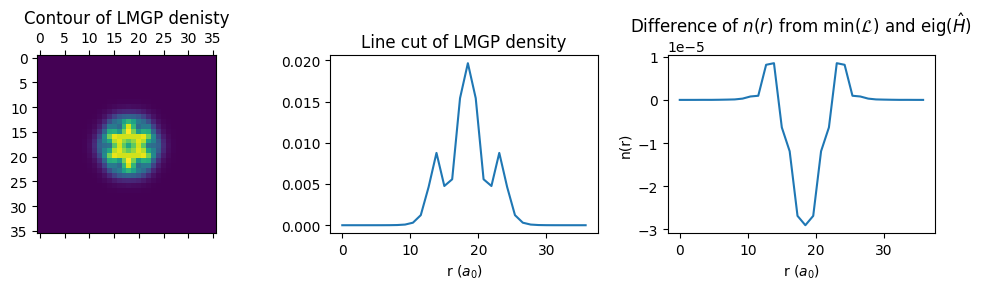

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
r = np.linspace(0,ions.cell[2][2],len(rho_h[18,18,:].ravel()))
axs[1].plot(r, rho_h[18,18,:].ravel())
axs[2].plot(r, rho_h[18,18,:].ravel()-rho0[18,18,:].ravel())
axs[2].set_ylabel('n(r)')
axs[1].set_xlabel('r ($a_0$)')
axs[2].set_xlabel('r ($a_0$)')
axs[0].matshow(rho_h[:,:,15])
axs[0].set_title("Contour of LMGP denisty")
axs[1].set_title("Line cut of LMGP density")
axs[2].set_title("Difference of $n(r)$ from min($\mathcal{L}$) and eig($\hat H$)")
plt.tight_layout()

## Time propagation after `kick`
Give momentum $k$ along specific direction to each KS orbital

$$
\phi(r,t_0) = \phi(r) e^{ikr}
$$

In [45]:
from dftpy.constants import TIME_CONV, LEN_CONV, ENERGY_CONV
as2au = TIME_CONV['s']['au']*1e-18
bohr = LEN_CONV['Angstrom']['Bohr']
ha = ENERGY_CONV['Hartree']['eV']

k = 0.01*bohr
interval = 1.0 * as2au
direction = 0 # 0, 1, 2 means x, y, z-direction, respectively

## Run with Crank Nicholson propagator

In [46]:
from dftpy.optimize import Dynamics


class Runner(Dynamics):

    def __init__(self, rho0, totalfunctional, k, direction, interval, max_steps):
        super(Runner, self).__init__()
        self.max_steps = max_steps
        self.totalfunctional = totalfunctional
        self.rho0 = rho0
        self.rho = rho0
        self.psi = initial_kick(k, direction, np.sqrt(self.rho0))
        #self.j = calc_j(self.psi)
        #potential = self.totalfunctional(self.rho0, current=self.j, calcType=['V']).potential
        potential = self.totalfunctional(self.rho0, calcType=['V']).potential
        hamiltonian = Hamiltonian(v=potential)
        self.prop = Propagator(hamiltonian, interval, name='crank-nicholson')
        self.dipole = []
        self.attach(self.calc_dipole) # this attaches the calc_dipole function to the observers list which runs after each time step.

    def step(self):
        self.psi, info = self.prop(self.psi)
        self.rho = calc_rho(self.psi)
        #self.j = calc_j(self.psi)
        #potential = self.totalfunctional(self.rho, current=self.j, calcType=['V']).potential
        potential = self.totalfunctional(self.rho, calcType=['V']).potential
        self.prop.hamiltonian.v = potential
        print("\r", end="")
        print(f"Progress: [{self.nsteps+1}/{self.max_steps}]", "|" * (self.nsteps*50 // self.max_steps), end="", flush=True)

    def calc_dipole(self):
        delta_rho = self.rho - self.rho0
        delta_mu = (delta_rho * delta_rho.grid.r).integral()
        self.dipole.append(delta_mu)

In [47]:
max_steps = 5000
runner = Runner(rho0, totalfunctional, k, direction, interval, max_steps)
runner()

Progress: [5000/5000] |||||||||||||||||||||||||||||||||||||||||||||||||

False

In [48]:
t = np.linspace(0, interval * max_steps, max_steps + 1)
mu = np.asarray(runner.dipole)

## Extraction of the optical spectrum

The time-dependent dipole moment change:
$$
\delta\mu(t) = \mu(t)-\mu(t_0)
$$

is related to the oscillator strength by Fourier transform
$$
S(\omega)=-\frac{2\omega}{k\pi}  \delta\mu(\omega) = -\frac{2\omega}{k\pi} \int_{t_0}^{t} \delta\mu(t)e^{i\omega t} dt 
$$

### Let's look at the time-dependent dipole moment

Text(0, 0.5, 'Dipole Moment (au)')

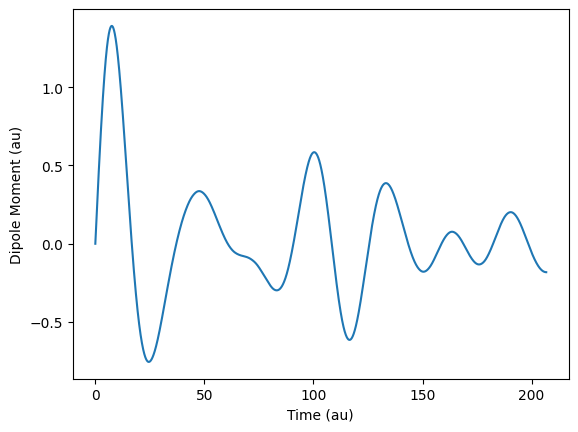

In [49]:
delta_mu = mu[:,0] - mu[0,0]
plt.plot(t, delta_mu)
plt.xlabel('Time (au)')
plt.ylabel('Dipole Moment (au)')

## Plot the optical spectra

In [50]:
KS_spectrum = np.loadtxt(fname='./KS_clusters/Mg8/Mg8_KS_spectrum.txt')

(0.0, 20.0)

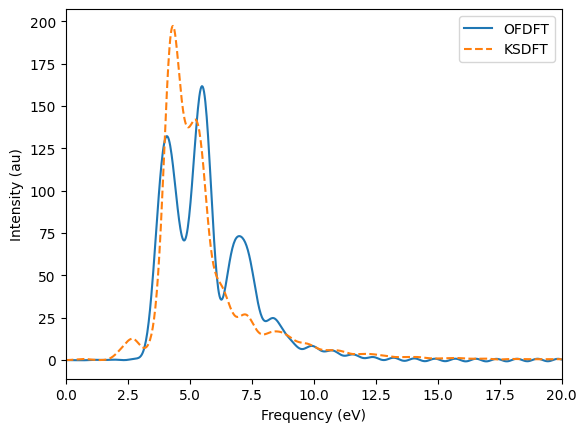

In [51]:
sigma = 0.03*(as2au**2)
omega, spectra = calc_spectra_mu(delta_mu, interval, sigma=sigma, kick=k)
plt.plot(omega*Units.Ha, spectra, '-',label='OFDFT')
plt.plot(KS_spectrum[0], KS_spectrum[1], '--', label='KSDFT')
plt.legend()
plt.xlabel('Frequency (eV)')
plt.ylabel('Intensity (au)')
plt.xlim(0, 20)

## Challenge 

Calculate the optical spectra of your own cluster

### Build a cluster with ASE


In [65]:
from ase.cluster.cubic import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [1, 3, 2] # this could be a variable
lc = 4.5 # this could be another variable
atoms = FaceCenteredCubic('Mg', surfaces, layers, latticeconstant=lc)
#atoms.set_cell([10,10,10])
atoms.wrap()
atoms.center(vacuum=10.0)

In [66]:
atoms.get_global_number_of_atoms()

13

In [67]:
import py3Dmol
from ase.io import write
write('cluster.xyz',atoms)
v = py3Dmol.view(data=open('./cluster.xyz','r').read(), style='sphere',linked=False)
v.addUnitCell()
v.zoomTo()
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# To build clusters of different atoms, use the following pseudopotentials: